## The Age of the Universe
Welcome to Lab 9!
<br>Elements of Data Science adapted from Berkeley Data8 

<br>**<center>Learning Goals**
|Area|Concept|
|---|---|
|Linear Regression|Examine the linear relationship between two variables|
|slope |change in depndent variable, y, for each change in independent variable,x |
|intercept|Value of dependent variable, y, at x = 0|
|r|correlation coefficient|
|bootstrap confidence interval|confidence interval on slope and intercept based on sampling|


Sometimes, the primary purpose of regression analysis is to learn something about the slope or intercept of the best-fitting line.  When we use a sample of data to estimate the slope or intercept, our estimate is subject to random error, just as in the simpler case of the mean of a random sample.

In this lab, we'll use regression to get an accurate estimate for the age of the universe, using pictures of exploding stars.  Our estimate will come from a sample of all exploding stars. We'll compute a confidence interval to quantify the error caused by sampling.

First, set up the tests and imports by running the cell below.

In [174]:
name = ...

In [1]:
## import statements
# These lines load the tests. 
from gofer.ok import check
import numpy as np
from datascience import *
import pandas as pd
import matplotlib
from matplotlib import patches
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore', FutureWarning)
plt.style.use('fivethirtyeight')
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import os
user = os.getenv('JUPYTERHUB_USER')

In [2]:
params = {'legend.fontsize': 'small',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)

### The Actual Big Bang Theory
In the early 20th century, the most popular cosmological theory suggested that the universe had always existed at a fixed size.  Today, the Big Bang theory prevails: Our universe started out very small and is still expanding.

A consequence of this is Hubble's Law, which says that the expansion of the universe creates the appearance that every celestial object that's reasonably far away from Earth (for example, another galaxy) is moving away from us at a constant speed.  If we extrapolate that motion backwards to the time when everything in the universe was in the same place, that time is (roughly) the beginning of the universe!

Scientists have used this fact, along with measurements of the current *location* and *movement speed* of other celestial objects, to estimate when the universe started.

The cell below simulates a universe in which our sun is the center and every other star is moving away from us.  Each star starts at the same place as the sun, then moves away from it over time.  Different stars have different directions *and speeds*; the arrows indicate the direction and speed of travel.

Run the cell, then move the slider to see how things change over time.

### <font color=blue> **Question 1A.** </font>
In the markdown cell below describe in your own words Hubble's Law and how we might use it to estimate the age of the universe

### <font color=blue> **Question 1B.** </font>
When did the universe start, in this example? Run the code and use the sliders to explore the relationships.

In [3]:
# Just run this cell.  (The simulation is actually not
# that complicated; it just takes a lot of code to draw
# everything.  So you don't need to read this unless you
# have time and are curious about more advanced plotting.)

num_locations = 20
example_velocities = Table().with_columns(
    "x", np.random.normal(size=num_locations),
    "y", np.random.normal(size=num_locations))
start_of_time = -15

def scatter_after_time(t, start_of_time, end_of_time, velocities, center_name, other_point_name, make_title):
    max_location = 1.1*(end_of_time-start_of_time)*max(max(abs(velocities.column("x"))), max(abs(velocities.column("y"))))
    new_locations = velocities.with_columns(
            "x", (t-start_of_time)*velocities.column("x"),
            "y", (t-start_of_time)*velocities.column("y"))
    plt.scatter(make_array(0), make_array(0), label=center_name, s=100, c="yellow")
    plt.scatter(new_locations.column("x"), new_locations.column("y"), label=other_point_name)
    for i in np.arange(new_locations.num_rows):
        plt.arrow(
            new_locations.column("x").item(i),
            new_locations.column("y").item(i),
            velocities.column("x").item(i),
            velocities.column("y").item(i),
            fc='black',
            ec='black',
            head_width=0.025*max_location,
            lw=.15)
    plt.xlim(-max_location, max_location)
    plt.ylim(-max_location, max_location)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().set_position(make_array(0, 0, 1, 1))
    plt.legend(bbox_to_anchor=(1.6, .7))
    plt.title(make_title(t))
    plt.show()

interact(
    scatter_after_time,
    t=widgets.FloatSlider(min=start_of_time, max=5, step=.5, value=0, msg_throttle=1),
    start_of_time=fixed(start_of_time),
    end_of_time=fixed(5),
    velocities=fixed(example_velocities),
    center_name=fixed("our sun"),
    other_point_name=fixed("other star"),
    make_title=fixed(lambda t: "The world {:01g} billion year{} in the {}".format(abs(t), "" if abs(t) == 1 else "s", "past" if t < 0 else "future")));

interactive(children=(FloatSlider(value=0.0, description='t', max=5.0, min=-15.0, step=0.5), Output()), _dom_c…

<font color='blue'>*Write your answer here, replacing this text.*</font>

### <font color=blue> **Question 2.** </font>
After 5 billion years (with the slider all the way to the right), stars with longer arrows are further away from the Sun.  Why?

<font color='blue'>*Write your answer here, replacing this text.*</font>

### Analogy: driving
Here's an analogy to illustrate how scientists use information about stars to estimate the age of the universe.

Suppose that at some point in the past, our friend Mei started driving in a car going at a steady speed of 60 miles per hour straight east.  We're still standing where she started.

We want to know how long she's been driving, but we forgot to record the time when she left.  If we find out that she's 120 miles away, and she's been going 60 miles per hour the whole time, we can infer that she left 2 hours ago.

One way we can compute that number is by fitting a line to a scatter plot of our locations and speeds.  It turns out that the *slope* of that line is the amount of time that has passed.  Run the next cell to see a picture:

In [4]:
# Run this cell to see a picture of Mei's locations over time.

mei_velocity = Table().with_columns("x", make_array(60), "y", make_array(0))
interact(
    scatter_after_time,
    t=widgets.FloatSlider(min=-2, max=1, step=.05, value=0, msg_throttle=1),
    start_of_time=fixed(-2),
    end_of_time=fixed(1),
    velocities=fixed(mei_velocity),
    center_name=fixed("Us"),
    other_point_name=fixed("Mei"),
    make_title=fixed(lambda t: "Mei's position {:01g} hour{} in the {}".format(abs(t), "" if abs(t) == 1 else "s", "past" if t < 0 else "future")));

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, min=-2.0, step=0.05), Output()), _dom_c…

The slope of the line is 2 hours.  (The units are vertical-axis units divided by horizontal-axis units, which are $\frac{\texttt{miles}}{\texttt{miles} / \texttt{hour}}$, or hours.)  So that's our answer.

Imagine that you don't know Mei's exact distance or speed, only rough estimates.  Then if you drew this line, you'd get a slightly bad estimate of the time since she left.  But if you measured the distance and speed of hundreds of people who left you at the same time going different speeds, and drew a line through them, the slope of that line would be a pretty good estimate of the time they left, even if the individual measurements weren't exactly right.

The `drivers.csv` dataset contains the speeds and distances-from-start of 100 drivers.  They all left the same starting location at the same time, driving at a fixed speed on a straight line away from the start.  The measurements aren't exact, so they don't fit exactly on a line.  We've created a scatter plot and drawn a line through the data.

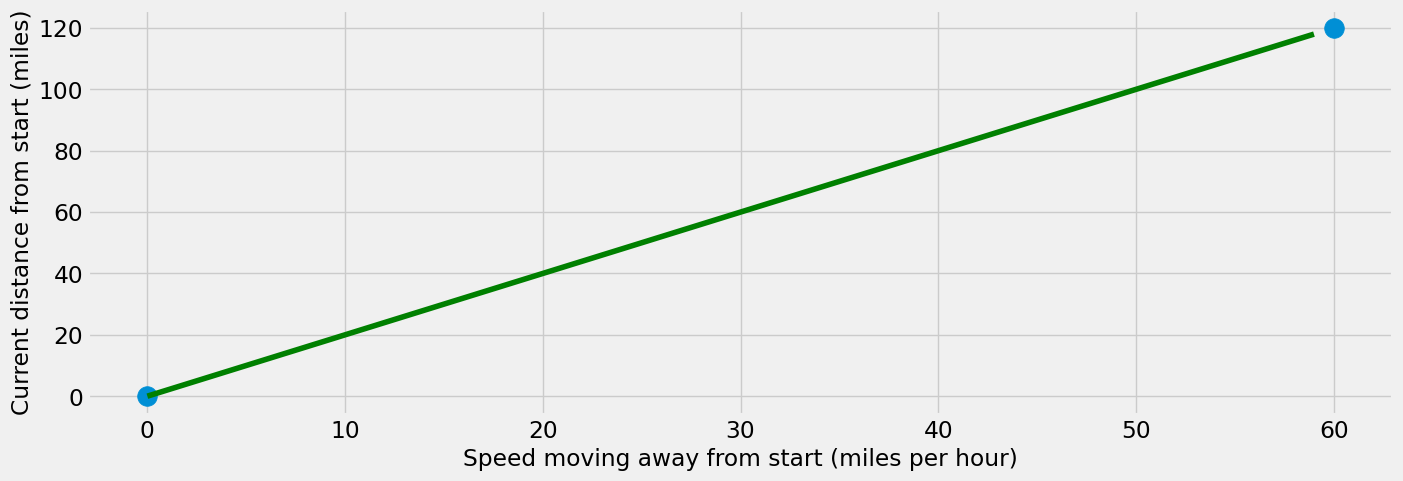

In [5]:
# Just run this cell to plot the data.
small_driving_example = Table().with_columns(
        "Name",                                       make_array("Us", "Mei"),
        "Speed moving away from us (miles per hour)", make_array(0,    60),
        "Current distance from us (miles)",           make_array(0,    120))

x = small_driving_example.column("Speed moving away from us (miles per hour)")
y = small_driving_example.column("Current distance from us (miles)")
plt.scatter(x,y, s=200)

# Now compute the fit and overlay
linear_model=np.polyfit(x,y,1)
linear_model_fn=np.poly1d(linear_model)
x_s=np.arange(0,60)
plt.plot(x_s,linear_model_fn(x_s),color="green")
plt.xlabel('Speed moving away from start (miles per hour)')
plt.ylabel("Current distance from start (miles)")
plt.show()

### <font color=blue> **Question 3.** </font>
By looking at the fit line, estimate how long ago (in hours) Mei left.

In [ ]:
# Just run this cell.
drivers= Table.read_table("drivers.csv")
xd,yd = drivers.column("Speed moving away from us (miles per hour)"),drivers.column("Current distance from us (miles)")
drivers

In [ ]:
plt.scatter(xd,yd, color='red')
plt.title('Cars leaving at same time but different speeds')
# Second approach to plotting
plt.xlabel('Speed moving away from start (miles per hour)')
plt.ylabel("Current distance from start (miles)")
#create scatterplot with regression line and confidence interval lines using Seaborn module
sns.regplot(x=xd, y=yd)
plt.show()

##### <font color=green>Fill in the start time you infer from the above line below.

In [ ]:
##### Fill in the start time you infer from the above line.
driving_start_time_hours = ...
driving_start_time_hours

In [ ]:
check('tests/q3.py')

### Back to cosmology
To do the same thing for the universe, we need to know the distance-from-Earth and speed-away-from-Earth of many celestial objects.  Using pictures taken by very accurate telescopes and a lot of physics, astronomers have been able to estimate both.  It turns out that *nearby supernovae* -- stars that have recently died and exploded -- are among the best sources of this data, because they are very easy to see.  This picture taken by the Hubble telescope shows an entire galaxy, with a single supernova - as bright by itself as billions of stars - at the bottom left.

<img src="supernova.jpg">

Our astronomical data for today will come from the [Supernova Cosmology Project](http://supernova.lbl.gov/union/) at Lawrence Berkeley Lab.  The original dataset is [here](http://supernova.lbl.gov/union/figures/SCPUnion2.1_mu_vs_z.txt), with (brief) documentation [here](http://supernova.lbl.gov/union/descriptions.html#Magvsz).  Each row in the table corresponds to a supernova near Earth that was observed by astronomers.  From pictures like the one above, the astronomers deduced how far away each supernova was from Earth and how fast it was moving away from Earth.  Their deductions were good, but not perfect.

Run the cell below to load the data into a table called `close_novas` and make a scatter plot. (If you prefer, you can also use the name `close_novae`; both are correct.)

### <font color=blue> **Question 4.** </font>
Looking this plot, make a guess at the age of the universe.

**Note**: Make sure you get the units right!  In case you need to know what a parsec is, it's a big unit of distance, equivalent to 30.86 trillion kilometers.

In [6]:
# Just run this cell.
close_novas = Table.read_table("close_novas.csv")
close_novas 

Speed (parsecs/year),Distance (million parsecs)
0.00873361,117.305
0.0153418,217.007
0.0162256,230.961
0.00528131,85.2853
0.0129474,185.051
0.0138862,212.841
0.0111837,151.728
0.0060085,82.6121
0.00838228,104.029
0.00812078,124.778


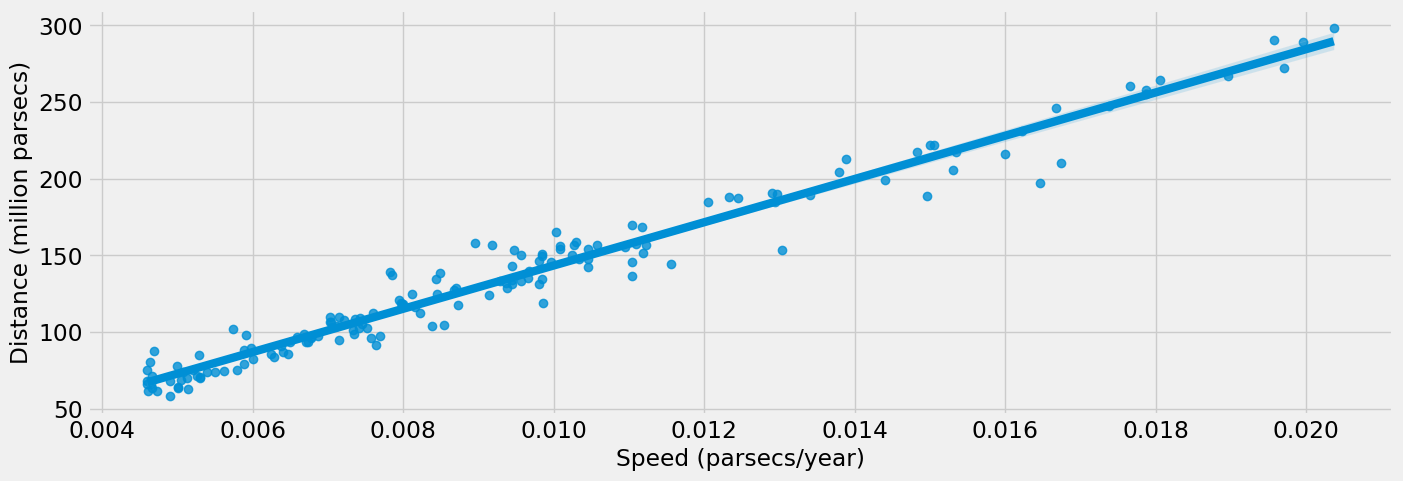

Speed (parsecs/year),Distance (million parsecs)
0.00873361,117.305
0.0153418,217.007
0.0162256,230.961
0.00528131,85.2853
0.0129474,185.051
0.0138862,212.841
0.0111837,151.728
0.0060085,82.6121
0.00838228,104.029
0.00812078,124.778


In [7]:
xn,yn = close_novas.column("Speed (parsecs/year)"),close_novas.column("Distance (million parsecs)")
sns.regplot(x=xn, y=yn)
plt.xlabel('Speed (parsecs/year)')
plt.ylabel('Distance (million parsecs)')
plt.show()

##### <font color=green>Fill in the first guess in years that you infer from the above line plotted above. Careful with the different units on each axis, million parsecs versus parsecs/year.

In [ ]:
first_guess_universe_age_years = ...  # Enter guess in years not billions of years

# This just shows your guess as a nice string, in billions of years.
"{:,} billion years".format(round(first_guess_universe_age_years / 1e9, 2))

In [ ]:
check('tests/q4.py')

### Fitting the line yourself
Displaying a fit line is visually helpful but we need to be able to calculate the slope as a number.  Recall that the least-squares regression line for our supernova data is:
* the line
* with the smallest average (over all the supernovae we observe)
* error
* squared
* where the error is

$$\text{the supernova's actual distance from Earth} - \text{the height of the line at that supernova's speed.}$$

In [8]:
## TEST Fitting a practice line with slope and intercept that you pick, a trial and error approach
slope = ...
intercept = ...
predict = close_novas.column('Speed (parsecs/year)')*slope+intercept
tbl = close_novas.with_column('predict',predict/1e6)
tbl

Speed (parsecs/year),Distance (million parsecs),predict
0.00873361,117.305,159.17
0.0153418,217.007,241.772
0.0162256,230.961,252.82
0.00528131,85.2853,116.016
0.0129474,185.051,211.843
0.0138862,212.841,223.577
0.0111837,151.728,189.797
0.0060085,82.6121,125.106
0.00838228,104.029,154.779
0.00812078,124.778,151.51


### <font color=blue> **Question 5.** </font>
Define a function called `errors`.  It should take three arguments:
1. a table like `close_novas` (with the same column names and meanings, but not necessarily the same data)
2. the slope of a line (a number)
3. the intercept of a line (a number).

It should return an array of the errors made when a line with that slope and intercept is used to predict distance from speed for each supernova in the given table.  (The error is the actual distance minus the predicted distance.)

In [ ]:
def errors(tbl, sl, inter):
    """ Functions to compute errors (residuals) using a given
    Table, tbl, slope, sl, and intercept, inter       """
    y = ...
    
    ## predicted values from line  
    predicted_y = ...  
    
    ## errors 
    error_values = ...
    
    return ...

#### <font color=blue> **Question 6.** </font>
Using the function `errors`, compute the errors for the line with slope `16000` and intercept `0` on the `close_novas` dataset.  Name that array `example_errors`.  These errors are what is termed residuals or the remaining, residual, value of the independent variable, 'Distance (million parsecs)', that is not fit by the linear function. Overlay a scatter plot of the errors below a scatter plot of the close_novas Table.

**Hint:** To make a scatter plot of the errors, plot the error for each supernova in the dataset contained in the array example_errors generated by the `errors()` function .  Put the actual speed on the horizontal axis and the error on the vertical axis.

In [ ]:
example_errors = errors(...,...,...)
example_errors

In [ ]:
close_novas.scatter(0,1)
plt.scatter(close_novas[0],example_errors, label='example errors = residuals')
plt.legend()
plt.show()

In [ ]:
check('tests/q6.py')

You should find that the errors are almost all negative.  That means our line is a little bit too steep.  Let's find a better one.

### <font color='green'>Residuals</font>
The residuals are the example errors that we plotted above but below our close_novas data in blue. Now we will interactively fit the close_novas data. Adjust the slope, m, and the intercept, b, to get the best fit. The sum of the square residuals is included in the legend.

In [ ]:
# Code to interactively optimize slope, run code, adjust sliders.
def residual(x,y,m,b):
    yhat = m*x+b
    res = y-yhat
    return res
def f(m, b):
    plt.figure(2)
   
    x = close_novas[0]
    y = close_novas[1]
    plt.scatter(x,y, label='Close Novas')
    xl = np.linspace(0, .025, num=1000)
    plt.plot(xl, m * xl + b, c='red', label='fit line')
    ssr = np.sum(residual(x,y,m,b)**2)
    plt.scatter(x, residual(x,y,m,b), s=20, c='chartreuse', label='residuals: ssr ='+str(round(ssr,2)))
    plt.xlabel('Speed (parsecs/year)')
    plt.ylabel('Distance (million parsecs)')
    plt.legend()
    plt.ylim(-100, 300)
    plt.xlim(.004, 0.022)
    plt.show()

interactive_plot = interactive(f, m=(0, 20000), b=(-50, 50, 1))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

<font color='green'>Enter your best slope, m, intercept, b, and compute mean squared error (MSE) based on ssr given in figure.</font>
$$ ssr = \sum(y-\hat{y})^2 $$
$$ MSE = \frac{\sum(y-\hat{y})^2}{n} $$

In [ ]:
m = ...
b = ...
n = ...  # Think about number of data points in a Table
MSE = ...

In Lab 09 when we examined the Old Faithful data and found a correlation and linear relationship between geyser eruption duration and wait time until the next eruption.  By calculating the correlation coefficient we can then compute the slope and intercept. See Section [15.1.2](https://inferentialthinking.com/chapters/15/1/Correlation.html#calculating-r).
***
Standard Units: To get correlation coefficient, r, we use standard units
***
$$\bar{x}=mean(x)$$
$$variance=mean((x-\bar{x})^2)=\frac{\sum(x-\bar{x})^2}{n}$$
$$SD_{population} = \sqrt{\frac{\sum(x-\bar{x})^2}{n}}$$
$$ Z = {\frac{(x-\bar{x})}{SD}}$$
$Z$ is the z-value which is the value of a given variable in standard units.<br>
***
Correlation coefficient: $r$
***
$$ r = np.mean(x_{standard}*y_{standard})$$

In [ ]:
speed_mean = ...
speed_std = ...
distance_mean = ...
distance_std = ...

close_novas_standard = Table().with_columns(
    "speed (standard units)", ...,
    "distance (standard units)", ...)
close_novas_standard

Use columns from the above table, `close_novas_standard`, to compute the correlation cofficient, r, and then the slope of the line in original units since the slope of the line in standard units is r. Read section [15.2.5](https://inferentialthinking.com/chapters/15/2/Regression_Line.html#the-equation-of-the-regression-line) to get the equations for the slope and intercept.

In [ ]:
r = ...
r

In [ ]:
slope = ...
slope

In [ ]:
intercept = ...
intercept

### Regression Functions
Use as part of a toolbox for later analysis

In [ ]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  
def correlation(t, label_x, label_y):
    return np.mean(standard_units(t.column(label_x))*standard_units(t.column(label_y)))

def slope(t, label_x, label_y):
    r = correlation(t, label_x, label_y)
    return r*np.std(t.column(label_y))/np.std(t.column(label_x))

def intercept(t, label_x, label_y):
    return np.mean(t.column(label_y)) - slope(t, label_x, label_y)*np.mean(t.column(label_x))

##### Example:

In [ ]:
correlation(close_novas, 'Speed (parsecs/year)','Distance (million parsecs)')

In [ ]:
slope(...,...,...)

In [ ]:
intercept(...,...,...)

There are many measures of the quality of a linear regression fit. One measure is the correlation coefficient squared which is the proportion of variation in the dependent variable, `Distance (million parsecs)` in this case, which can be attributed to variation in the dependent variable, `Speed (parsecs/year)` in this case. A value of 1.0 indicates that all the variation in the dependent variable can be attributed to variation in the independent variable.

In [ ]:
rsquared = ...

### <font color=blue> **Question 7.** </font>
Define a function called `fit_line`.  It should take a table like `close_novas` (with the same column names and meanings) as its argument.  It should return an array containing the slope (as item 0) and intercept (as item 1) of the least-squares regression line predicting distance from speed for that table. Use the functions defined above under **Regression Functions**.

In [ ]:
def fit_line(tbl, label_x, label_y):
    # Your code may need more than 1 line below here.
    slope_compute = ...
    intercept_compute = ...
    return make_array(slope_compute, intercept_compute)

In [ ]:
# Here is an example call to your function.  To test your function,
# figure out the right slope and intercept by hand.
example_table = Table().with_columns(
    "Speed (parsecs/year)", make_array(0, 1),
    "Distance (million parsecs)", make_array(1, 3))
fit_line(example_table, "Speed (parsecs/year)", "Distance (million parsecs)" )

In [ ]:
check('tests/q7.py')

### <font color=blue> **Question 8.** </font>
Use your function to fit a line to `close_novas`.

Then, set `new_errors` equal to the errors that we get calling `errors` with our new line. The following line will graph the corresponding residual plot with a best fit line.

Make sure that the residual plot makes sense (Hint: what qualities should the best fit line of a residual plot have?)

Create a residual function which returns an array of the unfit portion of the independent variable or residuals.

In [ ]:
def residual(x,y,m,b): # x data, y data, slope = m, intercept = b
    yhat = ...+... # fit of y
    res = y-yhat
    return res

In [ ]:
### Test of residual
residual(close_novas[0],...,16000,0)

In [ ]:
best_line = ...
m = ... # best line slope
b = ... # best line intercept
r_squared = correlation(..., ..., ...)**2
residuals = ... # Array with residuals/errors

# This code displays the residual plot, given your values for the best_line_slope and best_line_intercept
# This code displays the residual plot, given your values for the best_line_slope and best_line_intercept
plt.figure(2)
x = close_novas.column('Speed (parsecs/year)')
y = close_novas.column('Distance (million parsecs)')
plt.scatter(x,y, label='Close Novas')
xl = np.linspace(0, .025, num=1000)
plt.plot(xl, m * xl + b, c='red', label='fit line')
ssr = np.sum(residual(x,y,m,b)**2)
plt.scatter(x, residual(x,y,m,b), s=20, c='chartreuse', label='residuals: ssr ='+str(round(ssr,2)))
plt.xlabel('Speed (parsecs/year)')
plt.ylabel('Distance (million parsecs)')
plt.legend()
plt.ylim(-100, 300)
plt.xlim(.004, 0.022)
plt.show()


# This just shows your answer as a nice string, in billions of years.
print(f'Slope: {m:g} (corresponding to an estimated age of {m/1000:.4f} billion years)')
print(f'R**2 = {r_squared:.4f}')
print(f'ssr = {ssr:.4f}')

That slope (multiplied by 1 million) is an estimate of the age of the universe.  The current best estimate of the age of the universe (using slightly more sophisticated techniques) is 13.799 billion years.  
<br>
What was our determined age? Did we get close?<br>

<font color='blue'>*Write your answer here, replacing this text.*</font>


One reason our answer might be a little off is that we are using a sample of only some of the supernovae in the universe.  Our sample isn't exactly random, since astronomers presumably chose the novae that were easiest to measure (or used some other nonrandom criteria).  But let's assume it is.  How can we produce a confidence interval for the age of the universe?

### <font color=blue> **Bootstrap** </font>
The Bootstrap is a powerful means to estimate the variation in determined quantities such as slope and intercept by resampling the data used in the determination. See in Inferential Thinking about the Bootstrap in [13.2](https://inferentialthinking.com/chapters/13/2/Bootstrap.html?highlight=bootstrap)

### <font color=blue> **Question 9.** </font>
It's time to bootstrap so that we can quantify the variability in our estimate! Simulate 1000 resamples from `close_novas`.  For each resample, compute the slope of the least-squares regression line, and convert to billion years to compute an estimate of the age of the universe.  Store these ages in an array called `bootstrap_ages`, and then use them to compute a 95% confidence interval for the age of the universe.

**Note:** This might take up to a minute, and more repetitions will take even longer. See text: [Inferential Thinking 13.1](https://inferentialthinking.com/chapters/13/2/Bootstrap.html?highlight=bootstrap)

The `.sample()` Table method randomly samples the table with replacement. With replacement means that after a given row is put in the sample it is replaced and can possibly be resampled 1 or more times and some rows may never be sampled leading to different statistics including the slope and intercept for the data set stored in the table. If a number is specified in the `sample(5)` then that is the number od samples, otherwise the sampled data will have the same number of rows as the original Table. For example below with 5 samples.

In [ ]:
close_novas.sample(5)

In [ ]:
fit_line(close_novas.sample(5), "Speed (parsecs/year)", "Distance (million parsecs)" )

From this sample we get for the age of the universe:

In [ ]:
age_universe = fit_line(close_novas.sample(5), "Speed (parsecs/year)", "Distance (million parsecs)" )[0]/1000
age_universe

The `percentile()` function from the datscience module computes the value for the given percentile among the values in an array

In [ ]:
percentile(25, close_novas.sample(5)[1]) # 25 percentile of "Distance (million parsecs)"

Put in the 50th percentile = median of "Speed (parsecs/year)"

In [ ]:
percentile(..., close_novas.sample(5)[1])

Code the 97.5 percentile of "Distance (million parsecs)"

In [ ]:
percentile(...,...)

#### <font color='green'>Now use the bootstrap to determine the slope of sampled close_novas data and store in the array, `bootstrap_ages`.

In [ ]:
bootstrap_ages = make_array()
for i in np.arange(...):
    bootstrap_ages = np.append(bootstrap_ages,...)   # Remember use .sample() to resample the whole Table

In [ ]:
plt.hist(bootstrap_ages)

#### Now use the above samples in `bootstrap_ages` to examine uncertainty in slope determination and ultimately in the age of universe. Compute the range of values for the estimated age of the universe by generating the 95% confidence interval using the 2.5 and 97.5 percentiles from 1000 samples.

In [ ]:
lower_end = ... # Use percentile function
upper_end = ...

age_universe = np.mean(bootstrap_ages)
interval = (np.mean(age_universe-lower_end)) # Estimate of CI
Table().with_column("Age estimate", bootstrap_ages).hist(bins=np.arange(13, 15.5, .1), unit="billion years", edgecolor='grey')
plt.plot([lower_end,upper_end],[0,0],c='chartreuse',lw=10, label='95% CI')
plt.text(age_universe,2.1,f'Age of universe estimate: \n{age_universe:.1f} +/- {interval:.1f} billion years', size=11, color='red')
plt.vlines(age_universe,0,2,linestyles='dashed')
plt.legend()
print("95% confidence interval for the age of the universe: [{:g}, {:g}] billion years".format(lower_end, upper_end))

#### <font color=blue> **Question 9 Discussion.** </font>
What is the confidence interval on your estimated age of the universe?  Does the confidence interval on the slope include the value zero? If not, can we reject the null hypothesis that there is no correlation between close nova speed and distance?  Compare your result to the [Planck project 2015 results](https://arxiv.org/pdf/1502.01589.pdf), which estimated the age of the universe to be 13.799±0.021 billion years. Is the accepted age of the universe in this range? Conceptually, how did the bootstrap estimation of the uncertainty work?

In [ ]:
check('tests/q9.py')

#### <font color=blue> **Question 10.** </font>

At the end of each lab, please include a reflection. 
* How did this lab go? 
* Are you starting to get the hang of writing functions?
* Were there questions you found especially challenging you would like your instructor to review in class? 
* How long did the lab take you to complete?

Share your feedback so we can continue to improve this class!

**Insert a markdown cell below this one and write your reflection on this lab.**

Nice work, data astronomer!  **Please remember to submit!***

...

In [ ]:
# For your convenience, you can run this cell to run all the tests at once!
import glob
from gofer.ok import check
correct = 0
checks = [3,4,6,7,9]
total = len(checks)
for x in checks:
    print('Testing question {}: '.format(str(x)))
    g = check('tests/q{}.py'.format(str(x)))
    if g.grade == 1.0:
        print("Passed")
        correct += 1
    else:
        print('Failed')
        display(g)

print('Grade:  {}'.format(str(correct/total)))
print("Nice work ",name, user)
import time;
localtime = time.asctime( time.localtime(time.time()) )
print("Submitted @ ", localtime)